<a href="https://colab.research.google.com/github/jaimevt88/DL202001-U5/blob/master/SER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Speech Emotion Recognition**
### Developed by Luis Felipe Parra Gallego and Jaime Alberto Vergara Tejada

In [11]:
!rm -rf *
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1vhXvaH6yu2w6Ebz8J7LA-2KpUmKf_lrS' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1vhXvaH6yu2w6Ebz8J7LA-2KpUmKf_lrS" -O SER.zip && rm -rf /tmp/cookies.txt
!unzip SER.zip
!rm -rf SER.zip

--2020-06-08 22:58:01--  https://docs.google.com/uc?export=download&confirm=sXrE&id=1vhXvaH6yu2w6Ebz8J7LA-2KpUmKf_lrS
Resolving docs.google.com (docs.google.com)... 64.233.189.138, 64.233.189.139, 64.233.189.113, ...
Connecting to docs.google.com (docs.google.com)|64.233.189.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-2g-docs.googleusercontent.com/docs/securesc/0sb0dakm2t2hdt9cj5jm7ug9r596406f/m534sg6aagejabo31jddq9h2jnjjng9f/1591657050000/09223621612906059522/15718154237368781487Z/1vhXvaH6yu2w6Ebz8J7LA-2KpUmKf_lrS?e=download [following]
--2020-06-08 22:58:01--  https://doc-0c-2g-docs.googleusercontent.com/docs/securesc/0sb0dakm2t2hdt9cj5jm7ug9r596406f/m534sg6aagejabo31jddq9h2jnjjng9f/1591657050000/09223621612906059522/15718154237368781487Z/1vhXvaH6yu2w6Ebz8J7LA-2KpUmKf_lrS?e=download
Resolving doc-0c-2g-docs.googleusercontent.com (doc-0c-2g-docs.googleusercontent.com)... 74.125.203.132, 2404:6800:4008:c03::84
Connecting

In [0]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
import h5py
from sklearn.model_selection import train_test_split
import pickle
import os
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
from tensorflow.keras.callbacks import ModelCheckpoint

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def barplot_model(labels,train,test,ylabel='Accuracy',
                       title='Accuracy obtained in each architecture', 
                  lab1='Acc. train',lab2='Acc. test'): 
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10,7))
    rects1 = ax.bar(x - width/2, train, width, label=lab1)
    rects2 = ax.bar(x + width/2, test, width, label=lab2)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{:.2f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    autolabel(rects1)
    autolabel(rects2)
    fig.tight_layout()
    plt.show()

### **Model definition**

In [0]:
def get_rnn_model_A(num_classes,bn=False,neurons=[256,64],lookback = 10, feats =13 ,rnn='LSTM',
                    cells = 64, layers = 1,compile=True):
    print("using",num_classes,"classes")
 
    inputs = tf.keras.Input(shape = (lookback,feats), name="input_1")
    
    if rnn == 'LSTM' and layers == 1:
        layers = tf.keras.layers.LSTM(cells,activation = 'relu',dropout = 0.2)(inputs)
    elif rnn == 'LSTM' and layers == 2:
        layers = tf.keras.layers.LSTM(cells,activation = 'relu',dropout = 0.2, return_sequences=True)(inputs)
        layers = tf.keras.layers.LSTM(cells,activation = 'relu',dropout = 0.2)(layers)
    elif rnn == 'GRU' and layers == 1:
        layers = tf.keras.layers.GRU(cells,activation = 'relu',dropout = 0.2)(inputs)
    elif rnn == 'GRU' and layers == 2:
        layers = tf.keras.layers.GRU(cells,activation = 'relu',dropout = 0.2, return_sequences=True)(inputs)
        layers = tf.keras.layers.GRU(cells,activation = 'relu')(layers)
        
    layers = tf.keras.layers.Dense(neurons[0], activation=tf.nn.relu)(layers)
    #layers = tf.keras.layers.Dense(neurons[1], activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

### **Training function**

In [0]:
def train(model,x_train_emo,y_train_emo,x_test_emo,y_test_emo, batch_size, epochs, model_name=""):
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/"+model_name+"_"+"{}".format(time()))
    model.reset_states()
    print(x_test_emo.shape, y_test_emo.shape)
    print(x_train_emo.shape, y_train_emo.shape)
    print("\nDistribution of train classes")
    print(pd.Series(y_train_emo).value_counts())
    print("\nDistribution of test classes")
    print(pd.Series(y_test_emo).value_counts())
    checkpoint = ModelCheckpoint("BestModel/BestModel"+model_name+".hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1)
    history = model.fit(x_train_emo, y_train_emo, epochs=epochs, callbacks=[tensorboard, checkpoint],
              batch_size=batch_size,
              validation_data=(x_test_emo, y_test_emo))
    metrics = model.evaluate(x_train_emo, y_train_emo)
    return {k:v for k,v in zip (model.metrics_names, metrics)}, history.history

### **Data loading**

In [0]:
models_SER = {'A':{'lookback':10,'RNN':'LSTM','cells':64,'layers':1,'acc':0,'t':0}, 
              'B':{'lookback':20,'RNN':'LSTM','cells':64,'layers':1,'acc':0,'t':0},
              'C':{'lookback':10,'RNN':'LSTM','cells':256,'layers':1,'acc':0,'t':0},
              'D':{'lookback':20,'RNN':'LSTM','cells':256,'layers':1,'acc':0,'t':0},
              'E':{'lookback':10,'RNN':'LSTM','cells':64,'layers':2,'acc':0,'t':0},
              'F':{'lookback':20,'RNN':'LSTM','cells':64,'layers':2,'acc':0,'t':0},
              'G':{'lookback':10,'RNN':'LSTM','cells':256,'layers':2,'acc':0,'t':0}, 
              'H':{'lookback':20,'RNN':'LSTM','cells':256,'layers':2,'acc':0,'t':0},
              'I':{'lookback':10,'RNN':'GRU','cells':64,'layers':1,'acc':0,'t':0}, 
              'J':{'lookback':20,'RNN':'GRU','cells':64,'layers':1,'acc':0,'t':0},
              'K':{'lookback':10,'RNN':'GRU','cells':256,'layers':1,'acc':0,'t':0},
              'L':{'lookback':20,'RNN':'GRU','cells':256,'layers':1,'acc':0,'t':0},
              'M':{'lookback':10,'RNN':'GRU','cells':64,'layers':2,'acc':0,'t':0},
              'N':{'lookback':20,'RNN':'GRU','cells':64,'layers':2,'acc':0,'t':0},
              'O':{'lookback':10,'RNN':'GRU','cells':256,'layers':2,'acc':0,'t':0}, 
              'P':{'lookback':20,'RNN':'GRU','cells':256,'layers':2,'acc':0,'t':0}}

data_emo = {10:[], 20: [],50: [],100: []} 

Data for lookback = 10

In [0]:
with open('10/data_train.pkl','rb') as g: 
    y_train_emo, x_train_emo = pickle.load(g)
    data_emo[10].append(x_train_emo)
    data_emo[10].append(y_train_emo)


with open('10/data_test.pkl','rb') as g: 
    y_test_emo, x_test_emo = pickle.load(g)
    data_emo[10].append(x_test_emo)
    data_emo[10].append(y_test_emo)

Data for lookback = 20

In [0]:
with open('20/data_train.pkl','rb') as g: 
    y_train_emo, x_train_emo = pickle.load(g)
    data_emo[20].append(x_train_emo)
    data_emo[20].append(y_train_emo)


with open('20/data_test.pkl','rb') as g: 
    y_test_emo, x_test_emo = pickle.load(g)
    data_emo[20].append(x_test_emo)
    data_emo[20].append(y_test_emo)

Data for lookback = 50

In [0]:
with open('50/data_train.pkl','rb') as g: 
    y_train_emo, x_train_emo = pickle.load(g)
    data_emo[50].append(x_train_emo)
    data_emo[50].append(y_train_emo)


with open('50/data_test.pkl','rb') as g: 
    y_test_emo, x_test_emo = pickle.load(g)
    data_emo[50].append(x_test_emo)
    data_emo[50].append(y_test_emo)

Data for lookback = 100

In [0]:
with open('100/data_train.pkl','rb') as g: 
    y_train_emo, x_train_emo = pickle.load(g)
    data_emo[100].append(x_train_emo)
    data_emo[100].append(y_train_emo)


with open('100/data_test.pkl','rb') as g: 
    y_test_emo, x_test_emo = pickle.load(g)
    data_emo[100].append(x_test_emo)
    data_emo[100].append(y_test_emo)

### **Training for each model**

In [24]:
for key in models_SER:
    start_time = time()
    modelY = get_rnn_model_A(7,False,[256,64], models_SER[key]['lookback'], 13, 
                             models_SER[key]['RNN'], models_SER[key]['cells'], 
                             models_SER[key]['layers'])
    print(modelY.summary())
    print(models_SER[key])
    results, models_SER[key]['acc'] = train(modelY, data_emo[models_SER[key]['lookback']][0],
                                            data_emo[models_SER[key]['lookback']][1],
                                            data_emo[models_SER[key]['lookback']][2],
                                            data_emo[models_SER[key]['lookback']][3],
                                            batch_size=32, epochs=5, model_name=key)
    models_SER[key]['t'] = time() - start_time


using 7 classes
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 13)]          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                19968     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               16640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
output_1 (Dense)             (None, 7)                 1799      
Total params: 38,407
Trainable params: 38,407
Non-trainable params: 0
_________________________________________________________________
None
{'lookback': 10, 'RNN': 'LSTM', 'cells': 64, 'layers': 1, 'acc': 0, 't': 0}
(27262, 10, 13) (27262,)

### **Obtained accuracies**



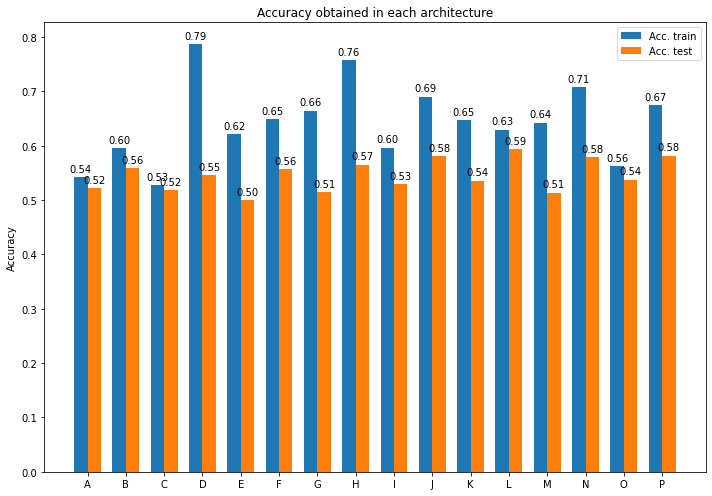

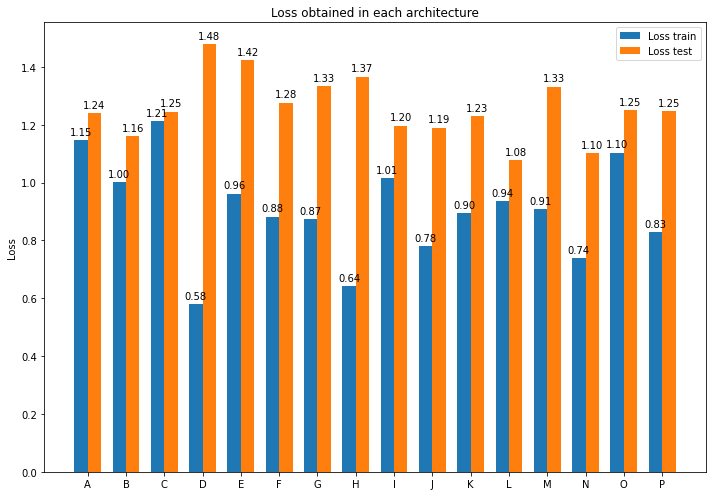

In [25]:
labels=[]
at2l=[]
lt2l=[]
av2l=[]
lv2l=[]
t2dl=[]
for key in models_SER:
    labels.append(key)
    j = models_SER[key]['acc']['val_accuracy'].index(max(models_SER[key]['acc']['val_accuracy']))
    at2l.append(models_SER[key]['acc']['accuracy'][j])
    lt2l.append(models_SER[key]['acc']['loss'][j])
    av2l.append(models_SER[key]['acc']['val_accuracy'][j])
    lv2l.append(models_SER[key]['acc']['val_loss'][j])
    t2dl.append(models_SER[key]['t'])


barplot_model(labels,at2l,av2l)   
barplot_model(labels,lt2l,lv2l,ylabel='Loss',title='Loss obtained in each architecture',
              lab1='Loss train',lab2='Loss test')

After trying with different values for loopbacks, we found that the model works better with lower values (we got better results with 10 and 20 frames compared to 50 and 100 frames). This seems to imply that the phenomenon does not have long memory. Also, better performance were obtained with GRU, probably due to fewer trainable parameters and the amount of samples in the dataset.

Adding dropout in recurrent networks avoid the overfitting experimented in the first experiments. It also slightly improved the performance in terms of validation accuracy.

### **Execution times**

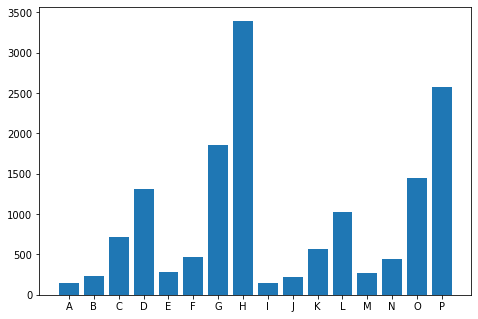

In [26]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(labels,t2dl)
plt.show()

### **Confusion matrix for the best model in terms of validation accuracy**

In [0]:
key = labels[av2l.index(max(av2l))]
modelY = get_rnn_model_A(7,False,[256,64], models_SER[key]['lookback'], 13, 
                             models_SER[key]['RNN'], models_SER[key]['cells'], 
                             models_SER[key]['layers'])
print(modelY.summary())
print(models_SER[key])

train(modelY, data_emo[models_SER[key]['lookback']][0],data_emo[models_SER[key]['lookback']][1],
data_emo[models_SER[key]['lookback']][2],data_emo[models_SER[key]['lookback']][3],batch_size=32, epochs=5, model_name=key)


Normalized confusion matrix
[[6.13167121e-01 2.28671601e-01 1.63615115e-02 6.19400078e-02
  4.01246591e-02 9.34943514e-03 3.03856642e-02]
 [2.82683307e-01 6.11388456e-01 9.51638066e-03 3.63494540e-02
  5.11700468e-02 1.56006240e-04 8.73634945e-03]
 [1.52770585e-02 3.62506473e-03 5.39357846e-01 8.59658208e-02
  1.11341274e-02 8.67426204e-02 2.57897462e-01]
 [9.05292479e-02 2.36768802e-02 1.22910864e-01 5.32729805e-01
  8.80919220e-02 6.58077994e-02 7.62534819e-02]
 [1.93922225e-01 4.12052537e-02 1.68941540e-01 1.54777234e-01
  3.36080350e-01 5.97476178e-02 4.53257790e-02]
 [1.35074291e-03 4.50247636e-04 1.89329131e-01 1.21566862e-02
  5.40297163e-03 7.50787933e-01 4.05222873e-02]
 [1.85528757e-03 4.17439703e-03 4.36920223e-01 2.22634508e-02
  1.76252319e-02 1.96196660e-01 3.20964750e-01]]


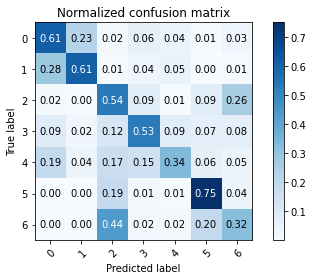

In [37]:
with open('20/data_train.pkl','rb') as g: 
    y_train_emo, x_train_emo = pickle.load(g)

with open('20/data_test.pkl','rb') as g: 
    y_test_emo, x_test_emo = pickle.load(g)


test_preds = modelY.predict(x_test_emo).argmax(axis=1)
plot_confusion_matrix(y_test_emo.astype(int), test_preds.astype(int), classes=np.r_[0,1,2,3,4,5,6], normalize=True)

### **Results with the implementation of Voice Activity Detection (VAD)**

**Labeling the silences:**

using 8 classes
(26299, 20, 13) (26299,)
(111008, 20, 13) (111008,)

Distribution of train classes
1.0    23031
5.0    19373
2.0    16804
7.0    16219
6.0    14682
3.0    11126
4.0     9773
dtype: int64

Distribution of test classes
1.0    6078
5.0    4455
2.0    3843
4.0    3769
7.0    3218
3.0    2798
6.0    2138
dtype: int64
Epoch 1/5
3469/3469 [==============================] - ETA: 0s - loss: 1.0821 - accuracy: 0.5838
Epoch 00001: val_accuracy improved from -inf to 0.46515, saving model to BestModel/BestModelvad.hdf5
3469/3469 [==============================] - 179s 52ms/step - loss: 1.0821 - accuracy: 0.5838 - val_loss: 1.5246 - val_accuracy: 0.4652
Epoch 2/5
3468/3469 [============================>.] - ETA: 0s - loss: 0.7493 - accuracy: 0.7141
Epoch 00002: val_accuracy improved from 0.46515 to 0.51778, saving model to BestModel/BestModelvad.hdf5
3469/3469 [==============================] - 179s 52ms/step - loss: 0.7493 - accuracy: 0.7141 - val_loss: 1.4514 - val_accuracy: 0.5178

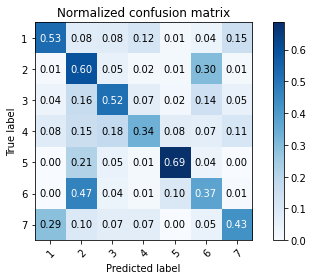

In [28]:
with open('vad/data_train.pkl','rb') as g: 
    y_train_emo, x_train_emo = pickle.load(g)
   
with open('vad/data_test.pkl','rb') as g: 
    y_test_emo, x_test_emo = pickle.load(g)

modelz = get_rnn_model_A(8,False,[256,64], 20, 13, 
                             models_SER[key]['RNN'], models_SER[key]['cells'], 
                             models_SER[key]['layers'])

train(modelz,x_train_emo,y_train_emo,x_test_emo,y_test_emo,
                                            batch_size=32, epochs=5, model_name='vad')

test_preds = modelz.predict(x_test_emo).argmax(axis=1)
plot_confusion_matrix(y_test_emo.astype(int), test_preds.astype(int), classes=np.r_[0,1,2,3,4,5,6,7], normalize=True)



**Deleting the silences:**

using 7 classes
(25124, 20, 13) (25124,)
(106912, 20, 13) (106912,)

Distribution of train classes
1    22475
5    19373
2    16742
6    14628
0    13019
3    11023
4     9652
dtype: int64

Distribution of test classes
1    5925
5    4455
2    3810
4    3696
3    2763
0    2337
6    2138
dtype: int64
Epoch 1/10
3341/3341 [==============================] - ETA: 0s - loss: 1.0780 - accuracy: 0.5870
Epoch 00001: val_accuracy improved from -inf to 0.52571, saving model to BestModel/BestModelvad-ns.hdf5
3341/3341 [==============================] - 185s 56ms/step - loss: 1.0780 - accuracy: 0.5870 - val_loss: 1.4060 - val_accuracy: 0.5257
Epoch 2/10
3341/3341 [==============================] - ETA: 0s - loss: 0.7316 - accuracy: 0.7237
Epoch 00002: val_accuracy improved from 0.52571 to 0.52862, saving model to BestModel/BestModelvad-ns.hdf5
3341/3341 [==============================] - 177s 53ms/step - loss: 0.7316 - accuracy: 0.7237 - val_loss: 1.4390 - val_accuracy: 0.5286
Epoch 3/10
3341/334

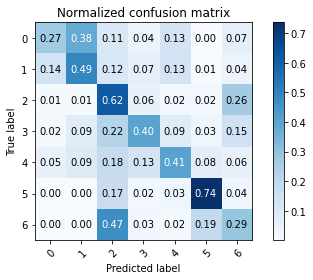

In [29]:
with open('vad-ns/data_train.pkl','rb') as g: 
    y_train_emo, x_train_emo = pickle.load(g)
   
with open('vad-ns/data_test.pkl','rb') as g: 
    y_test_emo, x_test_emo = pickle.load(g)

modelz = get_rnn_model_A(7,False,[256,64], 20, 13, 
                             models_SER[key]['RNN'], models_SER[key]['cells'], 
                             models_SER[key]['layers'])

train(modelz,x_train_emo,y_train_emo,x_test_emo,y_test_emo,
                                            batch_size=32, epochs=5, model_name='vad-ns')

test_preds = modelz.predict(x_test_emo).argmax(axis=1)
plot_confusion_matrix(y_test_emo.astype(int), test_preds.astype(int), classes=np.r_[0,1,2,3,4,5,6], normalize=True)


Silence suppression did not improve overall performance. This is probably related to the hypothesis that silence and other disfluencies give significant information about emotions (https://researchmgt.monash.edu/ws/portalfiles/portal/262318392/257088422_oa.pdf). On the other side, adding the silence as a new label supposes a more difficult problem.

Different strategies for data preparation could be further investigated:

https://ieeexplore.ieee.org/document/7952552

### **Clustering emotions ain terms of arousal - Binary classification problem**

In [30]:
!rm -rf arousal*
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Ed8ozsNRGlCGHCTRnuKD6gsYTF1AfoaQ' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Ed8ozsNRGlCGHCTRnuKD6gsYTF1AfoaQ" -O arousal.zip && rm -rf /tmp/cookies.txt
!unzip arousal.zip
!rm -rf arousal.zip

--2020-06-09 04:23:25--  https://docs.google.com/uc?export=download&confirm=&id=1Ed8ozsNRGlCGHCTRnuKD6gsYTF1AfoaQ
Resolving docs.google.com (docs.google.com)... 64.233.189.100, 64.233.189.113, 64.233.189.139, ...
Connecting to docs.google.com (docs.google.com)|64.233.189.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-2g-docs.googleusercontent.com/docs/securesc/sjhg1v47ce9c5jpli9urh3gn3hulhthd/rh9rvg595jv4jtm5i0t5jrqlvri0k3ls/1591676550000/13158967983899698144/08140005975198638056Z/1Ed8ozsNRGlCGHCTRnuKD6gsYTF1AfoaQ?e=download [following]
--2020-06-09 04:23:28--  https://doc-0c-2g-docs.googleusercontent.com/docs/securesc/sjhg1v47ce9c5jpli9urh3gn3hulhthd/rh9rvg595jv4jtm5i0t5jrqlvri0k3ls/1591676550000/13158967983899698144/08140005975198638056Z/1Ed8ozsNRGlCGHCTRnuKD6gsYTF1AfoaQ?e=download
Resolving doc-0c-2g-docs.googleusercontent.com (doc-0c-2g-docs.googleusercontent.com)... 74.125.203.132, 2404:6800:4008:c03::84
Connecting to 

In [0]:
with open('data_train_20.pkl','rb') as g:
  y_train_emo, x_train_emo = pickle.load(g)


with open('data_test_20.pkl','rb') as g:
  y_test_emo, x_test_emo = pickle.load(g)

In [33]:
modelW = get_rnn_model_A(2,False,[256,64], 20, 13, 'GRU', 256, 1)
print(modelW.summary())


using 2 classes
Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 13)]          0         
_________________________________________________________________
gru_14 (GRU)                 (None, 256)               208128    
_________________________________________________________________
dense_20 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_20 (Dropout)         (None, 256)               0         
_________________________________________________________________
output_1 (Dense)             (None, 2)                 514       
Total params: 274,434
Trainable params: 274,434
Non-trainable params: 0
_________________________________________________________________
None


(25124, 20, 13) (25124,)
(106912, 20, 13) (106912,)

Distribution of train classes
0    61766
1    45146
dtype: int64

Distribution of test classes
0    13166
1    11958
dtype: int64
Epoch 1/5
3341/3341 [==============================] - ETA: 0s - loss: 0.2755 - accuracy: 0.8842
Epoch 00001: val_accuracy improved from -inf to 0.83788, saving model to BestModel/BestModelarousal.hdf5
3341/3341 [==============================] - 182s 54ms/step - loss: 0.2755 - accuracy: 0.8842 - val_loss: 0.4062 - val_accuracy: 0.8379
Epoch 2/5
3340/3341 [============================>.] - ETA: 0s - loss: 0.1633 - accuracy: 0.9363
Epoch 00002: val_accuracy did not improve from 0.83788
3341/3341 [==============================] - 175s 52ms/step - loss: 0.1633 - accuracy: 0.9363 - val_loss: 0.5300 - val_accuracy: 0.8351
Epoch 3/5
3341/3341 [==============================] - ETA: 0s - loss: 0.1411 - accuracy: 0.9454
Epoch 00003: val_accuracy improved from 0.83788 to 0.83884, saving model to BestModel/BestMode

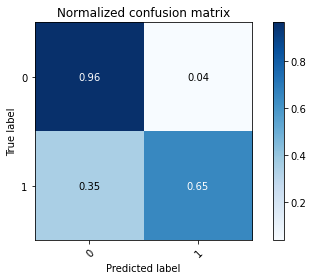

In [34]:
results, acc = train(modelW, x_train_emo,
                    y_train_emo,
                    x_test_emo,
                    y_test_emo,
                    batch_size=32, epochs=5, model_name='arousal')

test_preds = modelW.predict(x_test_emo).argmax(axis=1)
plot_confusion_matrix(y_test_emo.astype(int), test_preds.astype(int), classes=np.r_[0,1], normalize=True)

Adding dropout in recurrent networks avoid the overfitting experimented in the first experiments. It also slightly improved the performance in terms of validation accuracy